## 下载数据

In [17]:
import os

if "aclImdb" not in os.listdir():
    os.system("wget http://s3.amazonaws.com/text-datasets/aclImdb.zip")
    os.system("unzip aclImdb.zip")
    os.rmdir("aclImdb.zip")

## 加载数据

In [18]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [19]:
texts[0], labels[0]

('Terrible use of scene cuts. All continuity is lost, either by awful scripting or lethargic direction. That villainous robot... musta been a jazz dancer? Also, one of the worst sound tracks I\'ve ever heard (monologues usually drowned out by music.) And... where\'d they get their props? That ship looks like a milk carton... I did better special effects on 8mm at the age of 13!<br /><br />I\'d recommend any film student should watch this flick (5 minutes at a time) so as to learn how NOT to produce a film. Or... was it the editors\' fault?<br /><br />It\'s really too bad, because the scenario was actually a good concept... just poorly executed all the way around. (Sorry Malcom. You should have sent a "stunt double". You\'re too good an actor for such a stink-bomb.)',
 0)

## 分词

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 长度限制
maxlen = 100
# 在training_samples个句子上训练
training_samples = 200
# 在validation_samples个句子上验证
validation_samples = 10000
# 只考虑数据集内前max_words个最常见的词
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## 下载Glove词向量

In [21]:
import os

if "glove.6B" not in os.listdir():
    os.mkdir("glove.6B")
    os.chdir("glove.6B")
    os.system("wget https://nlp.stanford.edu/data/glove.6B.zip")
    os.system("unzip glove.6B.zip")
    os.system("rm glove.6B.zip")
    os.chdir("..")

## 加载Glove词向量

In [22]:
glove_dir = 'glove.6B'
embeddings_index = {}
# 100d 即 100维
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

## 构建词嵌入矩阵

In [24]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(10000, 100)

## 定义模型

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## 加载预训练词向量

In [27]:
model.layers[0].set_weights([embedding_matrix])
# 禁止更新预训练词向量
model.layers[0].trainable = False

## 训练模型

In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 126ms/step - loss: 2.7022 - acc: 0.4450 - val_loss: 1.3621 - val_acc: 0.4991
Epoch 2/10
7/7 [==============================] - 1s 114ms/step - loss: 0.5680 - acc: 0.7450 - val_loss: 1.4549 - val_acc: 0.5011
Epoch 3/10
7/7 [==============================] - 1s 110ms/step - loss: 0.3807 - acc: 0.8500 - val_loss: 0.8097 - val_acc: 0.5347
Epoch 4/10
7/7 [==============================] - 1s 110ms/step - loss: 0.3029 - acc: 0.8650 - val_loss: 0.7478 - val_acc: 0.5491
Epoch 5/10
7/7 [==============================] - 1s 111ms/step - loss: 0.2713 - acc: 0.8950 - val_loss: 0.8226 - val_acc: 0.5138
Epoch 6/10
7/7 [==============================] - 1s 112ms/step - loss: 0.1306 - acc: 0.9900 - val_loss: 0.7573 - val_acc: 0.5495
Epoch 7/10
7/7 [==============================] - 1s 111ms/step - loss: 0.0660 - acc: 1.0000 - val_loss: 0.9208 - val_acc: 0.5433
Epoch 8/10
7/7 [==============================] - 1s 109ms/step - loss: 0.0916 - acc: 0.98

## 查看模型性能随时间变化

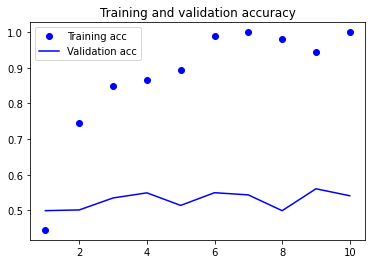

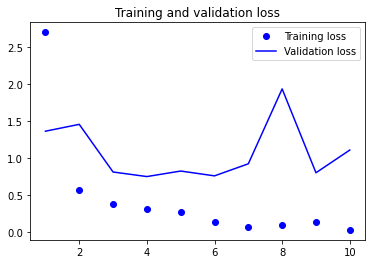

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 画图结果来看结果并不好，可能是因为只选择了200个随机样本

## 看看如果不使用预训练词向量，模型性能如何

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 140ms/step - loss: 0.6960 - acc: 0.4850 - val_loss: 0.6928 - val_acc: 0.5075
Epoch 2/10
7/7 [==============================] - 1s 120ms/step - loss: 0.4828 - acc: 0.9850 - val_loss: 0.6914 

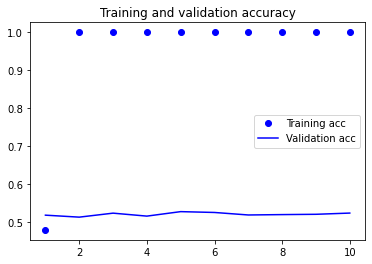

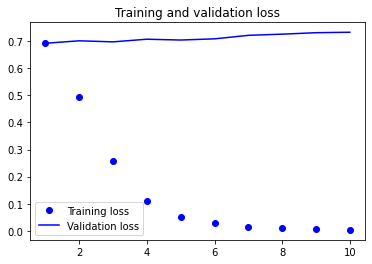

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 现在开始，使用测试集来测试模型性能

In [32]:
# 加载测试集
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
    texts.append(f.read())
    f.close()
    if label_type == 'neg':
        labels.append(0)
    else:
        labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

## 先用第二个模型来预测看看

In [33]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.7543 - acc: 0.5000


[0.7543354034423828, 0.5]

## 加载第一个模型测试

In [53]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.7434 - acc: 0.5000


[0.7433735132217407, 0.5]